# TransparentCalifornia Cohort Analysis

This notebook tries to take yearly public salary data and create cohorts over time of similar rows by grouping by
- Year 
- Number of years employed by the State of California
- Number of years with a Job Title
- Job Title

This, for example, puts all the 2013 salary entries for people who started state service in 2012 as 
Correctional Officers who stayed in the same job in 2013 as a cohort.

This makes it possible to compare cohorts over time and try to approximately answer questions like these:
- Did people who made below median salary in their cohort in one year continue to be below median <x> years later?
- How substantial is the effect?
- Is there a difference in median salary between men and women in a particular cohort?

## Import Libraries

In [1]:
import sys
!{sys.executable} -m pip install pandas matplotlib ipywidgets scipy pandas_profiling > /dev/null
!{sys.executable} -m pip install genderize gender_guesser seaborn statsmodels datadotworld[pandas] > /dev/null
!{sys.executable} -m pip install pandasql > /dev/null


import requests
from io import StringIO
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib
%matplotlib inline
from genderize import Genderize
import gender_guesser.detector as gender
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import datadotworld as dw
import sqlite3
import warnings
from pandasql import sqldf
warnings.simplefilter(action='ignore', category=FutureWarning)


You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Read in data from TransparentCalifornia

In [2]:
df = None
for year in range(2011,2020):    
    year_df = pd.read_csv(f'TransparentCalifornia/state-of-california-{year}.csv.zip', compression='zip')
    for col in ['Base Pay', 'Benefits', 'Other Pay', 'Total Pay', 'Overtime Pay', 'Total Pay & Benefits']:
        year_df[col] = pd.to_numeric(year_df[col], errors='coerce').astype('float64').round(2)
    year_df['Job Title'] = year_df['Job Title'].str.title().str.strip()
    year_df['Employee Name'] = year_df['Employee Name'].str.title()
    print(f'Year {year} Rows {len(year_df)}')
    df = year_df if df is None else df.append(year_df)

Year 2011 Rows 246599
Year 2012 Rows 244881
Year 2013 Rows 235071
Year 2014 Rows 240531
Year 2015 Rows 246273


/Users/bryanchan/.pyenv/versions/3.7.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Year 2016 Rows 248279
Year 2017 Rows 247697
Year 2018 Rows 253503
Year 2019 Rows 260277


In [3]:
print(df.dtypes)

Employee Name            object
Job Title                object
Base Pay                float64
Overtime Pay            float64
Other Pay               float64
Benefits                float64
Total Pay               float64
Total Pay & Benefits    float64
Year                      int64
Notes                    object
Agency                   object
Status                   object
dtype: object


# Guess at Genders from Names

In [4]:
df['First Name'] = df['Employee Name'].str.split(n=2).str[0]

In [5]:
d = gender.Detector()
df['Gender'] = df['First Name'].apply(lambda name: d.get_gender(name.title()))

In [6]:
df[['First Name', 'Gender']][0:100]

,First Name,Gender
0,Mohammad,male
1,Gertrudis,female
2,Joseph,male
3,Thomas,male
4,Curtis,male
...,...,...
95,Michael,male
96,Theodore,male
97,Dennis,male
98,Wadsworth,unknown


### Gender Distribution

<AxesSubplot:>

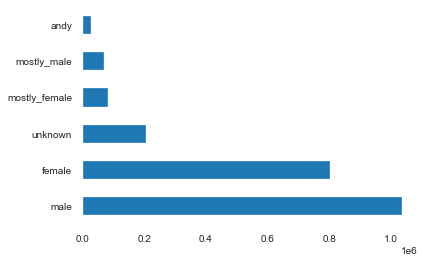

In [7]:
df['Gender'].value_counts().plot(kind='barh')

# Plot the Non-Adjusted Gender Gap
Note on how to interpret this -- it's an interesting barometer, but does not by itself point towards any specific causes of disparity

In [8]:
median_salary_df = df.groupby(['Gender'])['Base Pay'].median()
median_salary_df.sort_values()

Gender
female           51399.610
mostly_female    53748.000
unknown          55787.495
mostly_male      59676.845
andy             60797.245
male             63782.960
Name: Base Pay, dtype: float64

# Create Cohorts for Comparison
Try to create groups of people who started with Job Title `A` in a particular year and had Job Title `B` in a later year.

To avoid comparing apples to oranges, we want to only include people of roughly equal seniority in state service in the cohort.  And only want to compare people who did not switch roles in the years of interest (which makes understanding base salary difficult). 

Let's build cohorts step by step:

### 1) Group to one row per Employee Name per Year

In [9]:
initial_length = len(df)
print(f'Initial length rows={len(df)}')

df['Year in Job'] = df.groupby(['Employee Name', 'Job Title'])['Year'].rank("dense", ascending=True)

group_df = df.groupby(['Gender', 'First Name', 'Employee Name', 'Year'], as_index=False).agg(
    total_base_pay = ('Base Pay', 'sum'), 
    job_title = ('Job Title', 'first'),
    other_titles = ('Job Title', lambda x: '|'.join(x[1:])),
    job_count = ('Base Pay', lambda x: len(x)),
    benefits = ('Benefits', 'sum'),
    other_pay = ('Other Pay', 'sum'),
    overtime_pay = ('Overtime Pay', 'sum'),
    total_pay = ('Total Pay', 'sum'),
    total_pay_and_benefits = ('Total Pay & Benefits', 'sum'),
    min_year_in_job = ('Year in Job', min),
    max_year_in_job = ('Year in Job', max)    
).rename(columns={
    'total_base_pay': 'Base Pay',
    'job_title': 'Job Title',
    'other_titles': 'Other Job Titles',
    'job_count': 'Job Count In Year',
    'benefits': 'Benefits',
    'other_pay': 'Other Pay',
    'overtime_pay': 'Overtime Pay',
    'total_pay': 'Total Pay',
    'total_pay_and_benefits': 'Total Pay & Benefits',
    'min_year_in_job': 'Min Years In Job',
    'max_year_in_job': 'Max Years in Job'
})

print(f'1) Grouped rows={len(group_df)}')

Initial length rows=2223111
1) Grouped rows=2164857


### 2) Ignore rows in their last year in the database (may be partial year)

In [10]:
group_df['Reverse Rank'] = group_df.groupby(['Employee Name'])['Year'].rank("dense", ascending=False)
filtered_df = group_df[group_df['Reverse Rank'] > 1]
print(f'2) Removed rows from people who are in their last year.  rows={len(filtered_df)}')


2) Removed rows from people who are in their last year.  rows=1745635


### 3) Ignore people who were in the database at the start (they have unknown seniority)

In [11]:
min_year_df = filtered_df.groupby(['Employee Name'])['Year'].min().rename('First Year in DB')
filtered_df = pd.merge(filtered_df, min_year_df, on='Employee Name')
filtered_df = filtered_df[filtered_df['First Year in DB'] != 2011]
print(f'3) Removed rows for people whose first year is 2011 rows={len(filtered_df)}')


3) Removed rows for people whose first year is 2011 rows=383358


### 4) Remove rows where there is more than one job or person

In [12]:
filtered_df = filtered_df[filtered_df['Job Count In Year'] == 1]
print(f'4) Removed with more than one job or person rows={len(filtered_df)}')

4) Removed with more than one job or person rows=380525


### 5) Remove the first year someone is in their job (likely partial year)

In [13]:
filtered_df = filtered_df[filtered_df['Min Years In Job'] > 1]
print(f'5) Removed first year in job rows={len(filtered_df)}')

5) Removed first year in job rows=207082


### 6) Calculate Percentile Ranks for Base Pay within Job Title + Year + Years in Job + First Year in DB

In [14]:
cohort_columns = ['Job Title', 'Min Years In Job', 'Year', 'First Year in DB']
filtered_df['Percentile Rank in Cohort'] = filtered_df.groupby(cohort_columns)['Base Pay'].rank("dense", ascending=True, pct=True)
cohort_size_df = filtered_df.groupby(cohort_columns).size().rename('Cohort Size')
filtered_df = pd.merge(filtered_df, cohort_size_df, on=cohort_columns)
print(f'6) Added percentile ranks and cohort size rows={len(filtered_df)}')

6) Added percentile ranks and cohort size rows=207082


,Gender,First Name,Employee Name,Year,Base Pay,Job Title,Other Job Titles,Job Count In Year,Benefits,Other Pay,Overtime Pay,Total Pay,Total Pay & Benefits,Min Years In Job,Max Years in Job,Reverse Rank,First Year in DB,Percentile Rank in Cohort,Cohort Size
0,andy,Addison,Addison C Vaught,2017,1240.47,Park Aide (Seasonal),,1.0,0.00,0.00,0.00,1240.47,1240.47,2.0,2.0,2.0,2016,0.032520,123
1,andy,Aubrey,Aubrey L Carr,2017,11075.01,Park Aide (Seasonal),,1.0,1479.07,0.00,118.14,11193.15,12672.22,2.0,2.0,3.0,2016,0.585366,123
2,andy,Thanh,Thanh Thao T Hoang,2017,15590.22,Park Aide (Seasonal),,1.0,1990.63,0.00,0.00,15590.22,17580.85,2.0,2.0,3.0,2016,0.918699,123
3,female,Alyssa,Alyssa A Sanchez,2017,6916.29,Park Aide (Seasonal),,1.0,0.00,0.00,184.25,7100.54,7100.54,2.0,2.0,2.0,2016,0.252033,123
4,female,Alyssa,Alyssa J Ledesma,2017,4011.98,Park Aide (Seasonal),,1.0,0.00,0.00,0.00,4011.98,4011.98,2.0,2.0,3.0,2016,0.105691,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207077,unknown,Zaw,Zaw T Oo,2016,41068.92,Auditor I,,1.0,24451.84,8.84,0.00,41077.76,65529.60,2.0,2.0,4.0,2014,1.000000,1
207078,unknown,Zelia,Zelia M Navarrosalas,2016,29288.69,Motor Vehicle Assistant,,1.0,26599.63,0.00,307.04,29595.73,56195.36,2.0,2.0,2.0,2013,1.000000,1
207079,unknown,Zewugeberhan,Zewugeberhan Desta,2018,86031.79,Deputy Attorney General,,1.0,46215.58,0.00,0.00,86031.79,132247.37,4.0,4.0,2.0,2013,1.000000,1
207080,unknown,Zubeda,Zubeda N Kabuye,2017,53382.72,Licensed Vocational Nurse,,1.0,22759.08,2980.60,27556.45,83919.77,106678.85,2.0,2.0,3.0,2012,1.000000,1


## Save Initial Cohorts

In [15]:
filtered_df.to_csv('initial_cohorts.csv', index=True)

# Upload to data.world
client = dw.api_client()
client.upload_files('fryanpan13/california-public-salary-data',files='initial_cohorts.csv')

## Create cohort comparisons between years

In [26]:
pysqldf = lambda q: sqldf(q, globals())

cond_join= '''
    select 
        df_before.*,
        df_after.[Year] as 'Future Year',
        df_after.[Job Title] as 'Future Title',
        df_after.[Base Pay] as 'Future Base Pay',
        df_after.[Percentile Rank in Cohort] as 'Future Percentile Rank',
        df_after.[Cohort Size] as 'Future Cohort Size'
    from filtered_df as df_before
    left join filtered_df as df_after
    on
        df_before.[Employee Name] = df_after.[Employee Name] AND
        df_before.[Year] <= df_after.[Year]
    ORDER BY df_before.[Employee Name], df_before.[Year]
'''

compare_df = pysqldf(cond_join)

In [27]:
compare_df = compare_df.rename(columns={
    'Year': 'Initial Year',
    'Job Title': 'Initial Job Title',
    'Base Pay': 'Initial Base Pay',
    'Min Years In Job': 'Initial Years in Job',
    'Percentile Rank in Cohort': 'Initial Percentile Rank in Cohort',
    'Cohort Size': 'Initial Cohort Size'
}).drop(columns=['Other Job Titles', 'Max Years in Job', 'First Name'])
compare_df

,Gender,Employee Name,Initial Year,Initial Base Pay,Initial Job Title,Job Count In Year,Benefits,Other Pay,Overtime Pay,Total Pay,...,Initial Years in Job,Reverse Rank,First Year in DB,Initial Percentile Rank in Cohort,Initial Cohort Size,Future Year,Future Title,Future Base Pay,Future Percentile Rank,Future Cohort Size
0,unknown,A Y Vang,2016,48418.94,Correctional Officer,1.0,35889.61,7325.22,18146.05,73890.21,...,2.0,4.0,2015,0.369341,2243,2016,Correctional Officer,48418.94,0.369341,2243
1,unknown,A Y Vang,2016,48418.94,Correctional Officer,1.0,35889.61,7325.22,18146.05,73890.21,...,2.0,4.0,2015,0.369341,2243,2017,Correctional Officer,54944.98,0.288809,1945
2,unknown,A Y Vang,2016,48418.94,Correctional Officer,1.0,35889.61,7325.22,18146.05,73890.21,...,2.0,4.0,2015,0.369341,2243,2018,Correctional Officer,65445.19,0.425732,1818
3,unknown,A Y Vang,2017,54944.98,Correctional Officer,1.0,42778.66,5083.37,18803.40,78831.75,...,3.0,3.0,2015,0.288809,1945,2017,Correctional Officer,54944.98,0.288809,1945
4,unknown,A Y Vang,2017,54944.98,Correctional Officer,1.0,42778.66,5083.37,18803.40,78831.75,...,3.0,3.0,2015,0.288809,1945,2018,Correctional Officer,65445.19,0.425732,1818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444315,unknown,Zuwena I Lee,2018,73553.72,Correctional Officer,1.0,46349.22,4373.32,13981.94,91908.98,...,5.0,2.0,2014,0.921374,1729,2018,Correctional Officer,73553.72,0.921374,1729
444316,female,Zuzana Loviskova,2017,56662.56,Adoptions Specialist,1.0,15996.59,0.00,0.00,56662.56,...,2.0,3.0,2016,0.666667,6,2017,Adoptions Specialist,56662.56,0.666667,6
444317,female,Zuzana Loviskova,2017,56662.56,Adoptions Specialist,1.0,15996.59,0.00,0.00,56662.56,...,2.0,3.0,2016,0.666667,6,2018,Adoptions Specialist,62171.53,0.500000,6
444318,female,Zuzana Loviskova,2018,62171.53,Adoptions Specialist,1.0,19188.93,2790.84,0.00,64962.37,...,3.0,2.0,2016,0.500000,6,2018,Adoptions Specialist,62171.53,0.500000,6


## Save Cohort Comparisons

In [28]:
compare_df.to_csv('cohort_comparison.csv', index=True)

# Upload to data.world
client = dw.api_client()
client.upload_files('fryanpan13/california-public-salary-data',files='cohort_comparison.csv')